# Weather Generator, Annual Averages and Counts: Sabinal

The purpose of this notebook is to calculate annual average precipitation, PET, and deficit for comparison to 1991-2020 values and to count SPEI and SPI values below/above a threshold.

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as sstats
from math import exp
import datetime as dt
import seaborn as sns
import pickle
from copy import deepcopy

In [3]:
BasKey = "Sabinal"

In [4]:
NumReal = 1000

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
IN_DIR1 = r'C:\Users\nmartin\Documents\EAA_Drought_Future_Weather\NumModels\Final\%s\Results\Simulated' % BasKey
IN_DIR2 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\LOCA2\CN2031_2060'
IN_DIR3 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\Processed_Historical'
OUT_DIR = r'C:\Users\nmartin\Documents\EAA_Drought_Future_Weather\NumModels\Final\%s\Results\Processed' % BasKey

In [7]:
CNStartTS = pd.Timestamp( 2031, 1, 1, )
CNStopTS = pd.Timestamp( 2060, 12, 31, 23, 59, )
CNAnnIndexer = pd.date_range( start=CNStartTS, end=CNStopTS, freq='AS' )
len( CNAnnIndexer )

30

In [8]:
SimStartTS = pd.Timestamp(2024, 1, 1, 0, )
SimStopTS = pd.Timestamp( 2065, 12, 31, 23, 59, )
OAAnnIndexer = pd.date_range( start=SimStartTS, end=SimStopTS, freq='AS' )
len( OAAnnIndexer )

42

In [9]:
ProjFileRoot = "%s_R%d_DF.pickle"

In [10]:
ColsList = list()
for cR in range(1, NumReal+1):
    ColsList.append( "R%04d" % cR )
# end for

In [11]:
# our standard normal or ZScore parameters
ZMu = 0.0
ZStd = 1.0

## Collate Annual Averages

Go through all realizations and get annual averages for the entire simulation period. Then get just for our analysis interval and get overall averages for the analysis window.

In [12]:
AnnPreDF = pd.DataFrame( 0.0, index=OAAnnIndexer, columns=ColsList, dtype=np.float32 )
AnnEToDF = pd.DataFrame( 0.0, index=OAAnnIndexer, columns=ColsList, dtype=np.float32 )
AnnDefDF = pd.DataFrame( 0.0, index=OAAnnIndexer, columns=ColsList, dtype=np.float32 )

In [13]:
CNAnnPreDF = pd.DataFrame( 0.0, index=CNAnnIndexer, columns=ColsList, dtype=np.float32 )
CNAnnEToDF = pd.DataFrame( 0.0, index=CNAnnIndexer, columns=ColsList, dtype=np.float32 )
CNAnnDefDF = pd.DataFrame( 0.0, index=CNAnnIndexer, columns=ColsList, dtype=np.float32 )

In [14]:
for cR in range(1, NumReal+1):
    curCol = "R%04d" % cR
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (BasKey, cR) ) )
    curDF = pd.read_pickle( InFiler, compression='zip' )
    cPreDF = curDF[["Precip_mm"]].copy()
    cPreDF.columns = ["Pre_mm"]
    cEToDF = curDF[["ETo_mm"]].copy()
    cDefDF = curDF[["Def_mm"]].copy()
    curAnnPre = cPreDF.resample( 'AS' ).sum()
    curAnnETo = cEToDF.resample( 'AS' ).sum()
    curAnnDef = cDefDF.resample( 'AS' ).sum()
    # set to the correct time durations
    curCNAnnPre = curAnnPre.loc[CNStartTS:CNStopTS].copy()
    curCNAnnETo = curAnnETo.loc[CNStartTS:CNStopTS].copy()
    curCNAnnDef = curAnnDef.loc[CNStartTS:CNStopTS].copy()
    # now assign to our columns in tracking DataFrames
    AnnPreDF[curCol] = curAnnPre["Pre_mm"].to_numpy(dtype=np.float32)
    AnnEToDF[curCol] = curAnnETo["ETo_mm"].to_numpy(dtype=np.float32)
    AnnDefDF[curCol] = curAnnDef["Def_mm"].to_numpy(dtype=np.float32)
    CNAnnPreDF[curCol] = curCNAnnPre["Pre_mm"].to_numpy(dtype=np.float32)
    CNAnnEToDF[curCol] = curCNAnnETo["ETo_mm"].to_numpy(dtype=np.float32)
    CNAnnDefDF[curCol] = curCNAnnDef["Def_mm"].to_numpy(dtype=np.float32)
# end for

In [15]:
AnnPreDF["EnsAve"] = AnnPreDF.mean(axis=1)
AnnEToDF["EnsAve"] = AnnEToDF.mean(axis=1)
AnnDefDF["EnsAve"] = AnnDefDF.mean(axis=1)
CNAnnPreDF["EnsAve"] = CNAnnPreDF.mean(axis=1)
CNAnnEToDF["EnsAve"] = CNAnnEToDF.mean(axis=1)
CNAnnDefDF["EnsAve"] = CNAnnDefDF.mean(axis=1)
ColsList.append( "EnsAve" )

In [16]:
AnnSummDF = pd.DataFrame( index=[BasKey], data={"Pre_mm" : [CNAnnPreDF["EnsAve"].mean(),], "ETo_mm" : [CNAnnEToDF["EnsAve"].mean(),], 
                                                "Def_mm" : [CNAnnDefDF["EnsAve"].mean(),],} )

Output to a spreadsheet

In [17]:
OutFiler = os.path.normpath( os.path.join( OUT_DIR, "AnnualAverages_%s_%d-Real.xlsx" % (BasKey, NumReal) ) )
writer = pd.ExcelWriter( OutFiler )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00'})
cLabel = "Summary"
AnnSummDF.to_excel( writer, sheet_name=cLabel, )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in AnnSummDF:
    column_width = max(AnnSummDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = AnnSummDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Pre_mm_all"
AnnPreDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(AnnPreDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = AnnPreDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "ETo_mm_all"
AnnEToDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(AnnEToDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = AnnEToDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Def_mm_all"
AnnDefDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(AnnDefDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = AnnDefDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Pre_mm_CN"
CNAnnPreDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(CNAnnPreDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = CNAnnPreDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "ETo_mm_CN"
CNAnnEToDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(CNAnnEToDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = CNAnnEToDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Def_mm_CN"
CNAnnDefDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(CNAnnDefDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = CNAnnDefDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()

## Get SPEI and SPI Counts

Get our counts for SPEI $\le$ -1.5 and for SPI $\ge$ 1.5

In [18]:
F_SPEI = sstats.norm.cdf( -1.5, loc=ZMu, scale=ZStd )
F_SPEI, 1.0/60.0, 1.0/F_SPEI

(0.06680720126885807, 0.016666666666666666, 14.968446230453697)

In [19]:
F_SPI = sstats.norm.cdf( 1.5, loc=ZMu, scale=ZStd )
F_SPI, (1.0 - F_SPI), 1.0/60.0, (1.0/(1.0-F_SPI))

(0.9331927987311419,
 0.06680720126885809,
 0.016666666666666666,
 14.968446230453694)

In [20]:
InFiler = os.path.normpath( os.path.join( OUT_DIR, "%s_SPEI.xlsx" % BasKey ) )
SpeiDF = pd.read_excel( InFiler, sheet_name="SPEI_3mo", header=0, index_col=0, parse_dates=True )

In [21]:
InFiler = os.path.normpath( os.path.join( OUT_DIR, "%s_SPI.xlsx" % BasKey ) )
SpiDF = pd.read_excel( InFiler, sheet_name="SPI_3mo", header=0, index_col=0, parse_dates=True )

In [22]:
HistSPEIDF = SpeiDF[["SPEI (1981-2010)"]].copy()
L2SPEIDF = SpeiDF[["LOCA2 SPEI (2031-2060)"]].copy()
WGSPEIDF = SpeiDF[["WG SPEI (2031-2060)"]].copy()

In [23]:
HistSPEIDF = HistSPEIDF[HistSPEIDF["SPEI (1981-2010)"] <= -1.5].copy()
NumHist = len( HistSPEIDF )
NumHist

19

In [24]:
display( HTML( HistSPEIDF.to_html() ) )

,SPEI (1981-2010)
DateTime,
1997-09-01,-1.561299
1998-06-01,-1.524351
1999-02-01,-1.524993
1999-10-01,-1.785249
1999-11-01,-1.723735
2000-01-01,-1.860569
2006-02-01,-1.647939
2009-01-01,-1.632394
2009-02-01,-1.591074


In [25]:
HistSPEIDF["SPEI (1981-2010)"].min()

-2.128045320510864

In [26]:
L2SPEIDF = L2SPEIDF[L2SPEIDF["LOCA2 SPEI (2031-2060)"] <= -1.5].copy()
NumL2 = len( L2SPEIDF )
NumL2

4

In [27]:
display( HTML( L2SPEIDF.to_html() ) )

,LOCA2 SPEI (2031-2060)
DateTime,
2000-01-01,-1.622184
2011-04-01,-1.968390
2011-05-01,-1.804667
2011-06-01,-1.686124


In [28]:
L2SPEIDF["LOCA2 SPEI (2031-2060)"].min()

-1.968389749526978

In [29]:
WGSPEIDF["WG SPEI (2031-2060)"].min()

-1.418406128883362

In [30]:
WGSPEIDF = WGSPEIDF[WGSPEIDF["WG SPEI (2031-2060)"] <= -1.5].copy()
NumWG = len( WGSPEIDF )
NumWG

0

In [31]:
display( HTML( WGSPEIDF.to_html() ) )

,WG SPEI (2031-2060)
DateTime,


SPI

In [32]:
HistSPIDF = SpiDF[["SPI (1981-2010)"]].copy()
L2SPIDF = SpiDF[["LOCA2 SPI (2031-2060)"]].copy()
WGSPIDF = SpiDF[["WG SPI (2031-2060)"]].copy()

In [33]:
HistSPIDF = HistSPIDF[HistSPIDF["SPI (1981-2010)"] >= 1.5].copy()
NumHistSPI = len( HistSPIDF )
NumHistSPI

22

In [34]:
display( HTML( HistSPIDF.to_html() ) )

,SPI (1981-2010)
DateTime,
1997-06-01,1.818291
1998-10-01,2.158922
2000-11-01,1.939111
2000-12-01,1.685994
2001-01-01,1.774143
2002-07-01,1.860689
2002-08-01,1.743662
2002-09-01,2.011101
2004-04-01,1.823931


In [35]:
HistSPIDF["SPI (1981-2010)"].max()

3.035265922546387

In [36]:
L2SPIDF = L2SPIDF[L2SPIDF["LOCA2 SPI (2031-2060)"] >= 1.5].copy()
NumL2SPI = len( L2SPIDF )
NumL2SPI

43

In [37]:
display( HTML( L2SPIDF.to_html() ) )

,LOCA2 SPI (2031-2060)
DateTime,
1994-03-01,1.795133
1994-12-01,1.790014
1997-04-01,2.125592
1997-05-01,1.732889
1997-06-01,2.615713
1997-07-01,1.694334
1998-03-01,1.755940
1998-08-01,1.634066
1998-10-01,2.169239


In [38]:
L2SPIDF["LOCA2 SPI (2031-2060)"].max()

3.383488893508911

In [39]:
WGSPIDF = WGSPIDF[WGSPIDF["WG SPI (2031-2060)"] >= 1.5].copy()
NumWGSPI = len( WGSPIDF )
NumWGSPI

38

In [40]:
display( HTML( WGSPIDF.to_html() ) )

,WG SPI (2031-2060)
DateTime,
1994-12-01,2.892279
1996-12-01,1.570090
1997-06-01,2.479383
1997-07-01,1.979736
1998-08-01,1.869076
1998-09-01,1.975466
1998-10-01,3.500998
1998-12-01,2.548974
2000-11-01,3.336716


In [41]:
WGSPIDF["WG SPI (2031-2060)"].max()

5.238020420074463

## Box and Whisker Plots of Annual Totals

Make Box and Whisker Plot of the annual total precipitation depth collections.

In [42]:
modColsLister = deepcopy( ColsList )
modColsLister.remove( "EnsAve" )

In [43]:
WGAnnValuesList = list()

In [44]:
for tCol in modColsLister:
    WGAnnValuesList.append( CNAnnPreDF[tCol].to_numpy(dtype=np.float32).flatten() )
# end for

In [45]:
npWGAnnVals = np.concatenate( WGAnnValuesList )
NumWG = len( npWGAnnVals )
NumWG

30000

In [46]:
np.median( npWGAnnVals ), npWGAnnVals.mean(), npWGAnnVals.std()

(789.7976, 808.4451, 177.58168)

In [47]:
WGLabelsList = [ "WG 2031-2060" for x in range(NumWG) ]

In [48]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "%s_MonTS_2031to2060.xlsx" % BasKey ) )
MonTSDF = pd.read_excel( InFiler, sheet_name="Pre_mm", index_col=0, header=0 )

In [49]:
display( HTML( MonTSDF.head().to_html() ) )

,Year,Month,Ensemble Average,M51L,M51H,M52L,M52H,M53L,M53H,M55L,M55H,M56L,M56H,M57L,M57H,M58L,M58H,M59L,M59H,M60L,M60H,M61L,M61H,M62L,M62H,M63L,M63H,M64L,M64H,M65L,M65H,M66L,M66H,M67L,M67H,M68L,M68H,M69L,M69H,M70L,M70H,M71L,M71H,M72L,M72H,M73L,M73H,M74L,M74H,Check_EnsAve
YrMo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
203101,2031,1,38.309776,70.345543,3.856724,41.520622,44.823074,11.717721,42.056557,7.132967,4.762707,10.010750,39.419701,17.152899,33.164398,82.619438,42.225311,31.232740,61.486343,27.717424,92.034813,24.703970,44.243042,46.004841,15.880559,29.455311,17.395658,0.000000,31.108164,29.790848,8.838071,69.001701,39.413536,62.884853,123.704803,7.479362,27.030985,57.279587,117.738670,7.433432,5.062029,70.943222,9.334363,96.088516,108.674088,19.484838,4.429934,19.325115,6.240495,38.309776
203102,2031,2,32.764263,66.007935,28.094608,26.540590,11.754115,75.178490,10.997606,79.876152,41.471828,36.540123,24.352312,4.053299,33.321594,66.409027,10.465672,58.117558,10.153406,31.375891,72.677551,74.738617,8.572966,21.378828,74.099152,13.120440,10.648041,24.396284,8.226482,42.258194,32.865582,66.733910,18.452822,33.314293,28.621981,18.890354,0.175908,85.745926,8.901999,9.172692,0.056052,9.095342,29.611214,13.083749,39.598980,1.985372,65.502670,29.336975,51.183441,32.764263
203103,2031,3,47.144356,4.455525,57.865208,95.797897,66.751236,62.421303,51.852150,49.631779,30.916414,91.351585,25.293903,70.317459,1.711322,18.817030,7.241986,46.610119,12.159978,87.784615,0.483533,52.440998,21.707417,47.509136,11.877543,13.033782,10.583198,48.581261,27.606607,73.468391,24.100327,162.580566,15.473115,146.338654,65.810699,1.808474,40.223026,69.185471,3.810263,58.967110,34.985291,67.590919,101.102310,32.870022,92.697266,23.708420,66.410217,21.967426,50.739388,47.144356
203104,2031,4,51.219429,137.669174,83.043648,34.605957,48.422592,36.050434,68.665077,55.075150,22.336145,46.885864,100.600426,35.387421,52.122368,70.335342,37.168858,6.003369,102.026825,17.075819,56.237331,64.630966,36.805786,55.020119,32.999645,52.022617,38.358654,25.848526,52.515541,12.488296,49.695419,68.609993,63.480186,102.453026,63.210064,10.014184,22.977205,42.839039,65.556938,139.829056,18.341663,30.743923,21.034151,132.134094,60.411716,38.049709,22.983774,16.895321,6.432217,51.219418
203105,2031,5,99.475349,52.120041,56.617542,123.066101,12.131095,59.564747,102.223785,208.298737,50.147404,84.222710,260.955261,109.660187,48.349209,34.188835,238.732559,91.151993,156.702545,78.090050,265.634430,84.486938,15.758796,115.561317,98.857742,50.564804,53.952812,67.224930,116.030083,17.599178,191.184250,90.697784,60.723129,133.691650,162.421753,112.410004,52.370178,60.503506,99.693588,130.948822,115.603073,211.978363,22.756376,161.855270,26.071186,82.405579,98.742477,57.351837,52.563431,99.475365


In [50]:
dropCols = ["Month", "Ensemble Average", "Check_EnsAve" ]

In [51]:
MonTSDF.drop(columns=dropCols, inplace=True )

In [52]:
L2Cols = list( MonTSDF.columns )
L2Cols.remove("Year")

In [53]:
L2AnnDF = MonTSDF.groupby(by="Year").sum()

In [54]:
display( HTML( L2AnnDF.head().to_html() ) )

,M51L,M51H,M52L,M52H,M53L,M53H,M55L,M55H,M56L,M56H,M57L,M57H,M58L,M58H,M59L,M59H,M60L,M60H,M61L,M61H,M62L,M62H,M63L,M63H,M64L,M64H,M65L,M65H,M66L,M66H,M67L,M67H,M68L,M68H,M69L,M69H,M70L,M70H,M71L,M71H,M72L,M72H,M73L,M73H,M74L,M74H
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2031,1026.897597,687.233524,707.284162,644.542978,871.571301,729.246134,754.537020,579.348553,586.365499,716.041762,695.908514,653.981680,633.462083,373.741338,597.013625,840.206944,464.420659,650.510658,482.711982,331.783922,691.882031,524.253753,447.580407,518.353891,375.859382,881.074886,488.553782,997.147510,944.174028,673.548656,675.487755,964.732149,593.397438,587.175548,581.649054,644.384499,735.169687,640.182685,798.728800,402.619048,676.685222,793.776491,631.713241,698.254030,481.409273,318.355150
2032,858.986708,967.224544,954.921949,602.028514,486.902824,661.293912,690.504108,615.336736,749.539069,548.543491,780.976795,934.816889,861.469872,484.593677,607.366082,1117.866215,790.781399,1045.646511,958.884905,485.427377,803.187507,719.583134,977.253815,531.812268,787.383391,544.684873,1086.281559,487.697641,499.605780,685.759811,607.525549,909.065626,544.357500,334.953582,602.454795,764.965076,884.610121,505.232878,616.876762,431.136565,957.691661,480.402666,686.491337,882.408511,714.330230,534.286922
2033,676.897909,658.074741,594.191028,411.429522,406.447944,673.367867,548.153570,431.616067,825.079391,1306.246955,510.394888,369.998625,456.203192,935.451395,491.840040,527.844948,579.914274,970.764838,447.669857,567.849273,615.944735,558.237950,392.921821,596.716687,786.080206,786.482368,780.231857,635.466715,427.144068,640.060683,435.877125,906.628685,556.213355,871.512980,605.076211,948.852832,804.295691,411.356098,490.809993,562.945764,790.008641,399.622629,655.101160,645.189350,781.713737,679.125569
2034,866.270940,1026.766717,998.173736,569.708253,619.442623,434.808044,697.490257,634.934868,1345.610538,491.002400,936.321344,1056.856586,410.165854,441.511820,545.888568,1238.225435,407.062031,572.850350,453.407995,804.824910,673.190833,617.766847,445.580510,406.270794,717.931404,434.493619,756.418629,864.493429,811.454901,935.063732,772.742573,453.791324,862.293722,869.775523,516.943487,664.685516,644.315019,688.264455,667.877800,851.992948,338.240269,399.946958,649.644712,560.877117,634.001132,755.744308
2035,829.496018,524.173350,758.388641,993.855202,1283.000609,1214.066176,1113.212261,388.849463,416.011847,676.229237,923.270971,665.767757,646.184148,479.623616,917.131451,648.447128,570.209327,327.287155,1170.096319,588.077069,617.949513,578.559605,979.541115,647.391706,383.844563,941.501869,789.672495,512.932446,591.059922,754.522646,802.749176,748.968268,709.765492,1088.078466,542.536376,563.824303,693.035885,686.758725,825.580659,439.858153,1121.951949,491.460869,877.838711,784.629872,352.824227,830.750171


In [55]:
display( HTML( L2AnnDF.tail().to_html() ) )

,M51L,M51H,M52L,M52H,M53L,M53H,M55L,M55H,M56L,M56H,M57L,M57H,M58L,M58H,M59L,M59H,M60L,M60H,M61L,M61H,M62L,M62H,M63L,M63H,M64L,M64H,M65L,M65H,M66L,M66H,M67L,M67H,M68L,M68H,M69L,M69H,M70L,M70H,M71L,M71H,M72L,M72H,M73L,M73H,M74L,M74H
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2056,809.594463,545.435034,882.834147,772.795383,1082.019318,866.883914,810.458663,711.991668,1145.148696,497.681119,876.956306,809.704479,426.205214,353.850839,584.449238,584.426022,637.394912,570.355518,568.764947,332.836012,631.905981,445.331702,498.688804,769.314663,1013.430590,511.486058,646.642100,715.191039,678.362329,566.071404,769.784597,424.487595,597.344584,522.842182,785.555362,634.163930,594.034176,573.156431,377.508987,813.901336,610.624369,811.804957,950.622844,637.184308,1261.754693,688.495976
2057,513.137975,676.756766,696.568876,817.246071,840.022239,848.200609,672.857627,836.643722,1248.670329,1033.780943,589.941895,716.207321,717.770112,730.433886,584.328573,888.177120,515.064561,494.200712,555.844578,672.387785,597.725256,628.734245,439.793650,385.921488,639.664820,532.981314,566.990187,439.170736,501.048773,427.418315,559.179595,670.854140,698.405267,625.846748,448.169891,926.842085,721.333594,622.769139,711.108870,478.170356,568.509689,662.506920,706.563849,379.095768,700.627449,354.093699
2058,505.138491,493.127842,923.514877,492.601431,685.148170,515.869484,963.473690,480.141520,887.299849,1218.590124,416.542046,572.110320,766.106599,651.124372,553.797114,476.222092,754.936398,897.002315,386.473668,755.274065,631.267551,900.411003,758.156119,659.925733,716.943743,654.716248,739.755564,669.694469,915.507644,701.356949,467.760465,740.694062,984.176748,796.377140,845.565840,775.684356,495.785866,571.395777,579.449169,509.517016,532.693148,903.965763,1141.295348,671.293640,607.080730,683.271362
2059,365.066072,437.871628,763.819648,892.307017,1026.899869,638.094189,411.927722,393.044815,623.826460,859.589211,1007.036034,1069.368519,998.003296,746.449440,309.798293,592.147707,822.850199,433.991803,677.578879,630.577653,459.346881,555.810655,940.313561,772.884372,487.237911,744.513688,716.148425,603.962726,263.131709,1234.250860,437.507444,633.473918,442.469979,1036.591904,1032.532862,664.671968,851.954093,466.352552,927.668846,498.046143,481.023703,681.793773,556.504667,583.964552,734.301304,1059.589602
2060,694.225327,860.266120,830.662853,506.403467,930.992624,512.450163,431.721196,641.127405,598.673085,609.700224,716.174284,616.290071,461.367661,402.895779,433.811033,875.836637,518.620001,717.384408,748.218729,1119.215233,639.016048,685.783879,697.009230,871.159886,897.296029,620.319000,477.692802,836.277173,818.140721,710.497881,738.300073,823.004383,651.950673,713.518713,811.181146,603.056977,1008.614536,817.606908,299.323285,606.869599,596.314269,338.966563,806.035808,1047.720525,899.368459,521.753284


In [56]:
L2AnnValuesList = list()

In [57]:
for tCol in L2Cols:
    L2AnnValuesList.append( L2AnnDF[tCol].to_numpy(dtype=np.float32).flatten() )
# end for

In [58]:
npL2AnnVals = np.concatenate( L2AnnValuesList )
NumL2 = len( npL2AnnVals )
NumL2

1380

In [59]:
np.median( npL2AnnVals ), npL2AnnVals.mean(), npL2AnnVals.std()

(657.70154, 680.67126, 213.18925)

In [60]:
L2LabelsList = [ "LOCA2 2031-2060" for x in range(NumL2) ]

In [61]:
InFiler = os.path.normpath( os.path.join( IN_DIR3, "FBas_MetTS_1980to2020.xlsx" ) )
HODF = pd.read_excel( InFiler, sheet_name=BasKey, header=0, index_col=0, parse_dates=True )

In [62]:
display( HTML( HODF.head().to_html() ) )

,Pre_mm,MaxT_C,MinT_C,AveT_C,ETo_mm,Def_mm
DateTime,,,,,,
1980-01-01,0.0,17.577592,-2.841295,7.368149,1.794346,-1.794346
1980-01-02,0.0,18.744669,0.498631,9.621650,1.959683,-1.959683
1980-01-03,0.0,14.593520,3.375643,8.984581,1.919166,-1.919166
1980-01-04,0.0,15.898400,-3.112537,6.392932,1.738397,-1.738397
1980-01-05,0.0,18.564166,-1.864397,8.349884,1.884502,-1.884502


In [63]:
HODF = HODF[["Pre_mm"]].loc[pd.Timestamp( 1991, 1, 1, ):pd.Timestamp(2020, 12, 31, 23, 59, )].copy()

In [64]:
display( HTML( HODF.head().to_html() ) )

,Pre_mm
DateTime,
1991-01-01,0.000000
1991-01-02,4.785253
1991-01-03,2.755548
1991-01-04,3.250253
1991-01-05,1.677222


In [65]:
display( HTML( HODF.tail().to_html() ) )

,Pre_mm
DateTime,
2020-12-27,0.000017
2020-12-28,1.329345
2020-12-29,0.064786
2020-12-30,32.353908
2020-12-31,32.353908


In [66]:
HOAnnDF = HODF.resample( 'AS' ).sum()

In [67]:
display( HTML( HOAnnDF.head().to_html() ) )

,Pre_mm
DateTime,
1991-01-01,1033.144326
1992-01-01,1058.235371
1993-01-01,434.351745
1994-01-01,928.877604
1995-01-01,756.822039


In [68]:
display( HTML( HOAnnDF.tail().to_html() ) )

,Pre_mm
DateTime,
2016-01-01,1028.338187
2017-01-01,725.914820
2018-01-01,1208.377165
2019-01-01,553.594237
2020-01-01,673.764665


In [69]:
npHOAnnVals = HOAnnDF["Pre_mm"].to_numpy(dtype=np.float32).flatten()
NumHO = len( npHOAnnVals )
NumHO

30

In [70]:
np.median( npHOAnnVals ), npHOAnnVals.mean(), npHOAnnVals.std()

(744.55554, 808.65454, 270.706)

In [71]:
HOLabelsList = [ "Obs. 1991-2020" for x in range(NumHO) ]

Make the combined DataFrame for plotting

In [72]:
AllLabelsList = deepcopy( WGLabelsList )
AllLabelsList.extend( L2LabelsList )
AllLabelsList.extend( HOLabelsList )
len( AllLabelsList )

31410

In [73]:
npAllAnn = np.concatenate( [npWGAnnVals, npL2AnnVals, npHOAnnVals], )
len( npAllAnn )

31410

In [74]:
DataDict = { "Labels" : AllLabelsList, "AnnPre_mm" : npAllAnn, }
BwDF = pd.DataFrame( data=DataDict )

In [75]:
OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "BW_AnnPrecipDepth_%s.pdf" % BasKey ) )
OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "BW_AnnPrecipDepth_%s.svg" % BasKey ) )
OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "BW_AnnPrecipDepth_%s.png" % BasKey ) )

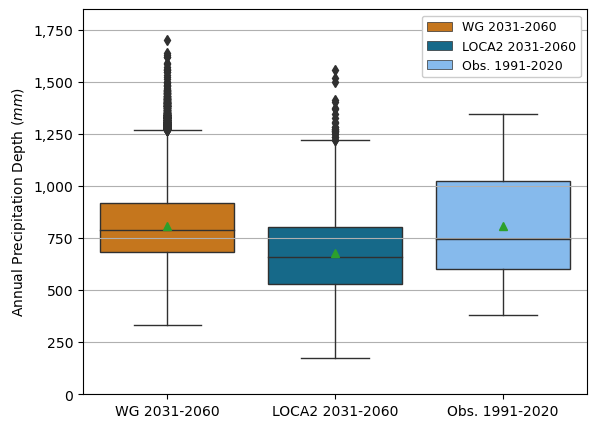

In [76]:
Fig1 = plt.figure()
Fig1.set_size_inches(6.5, 5.0)
ax11 = Fig1.add_subplot(111)
g1 = sns.boxplot( x="Labels", y="AnnPre_mm", hue="Labels", orient="v", 
                  linewidth=1.0, showmeans=True, dodge=False,
                  palette={ "Obs. 1991-2020" : "xkcd:sky blue",
                            "LOCA2 2031-2060" : "xkcd:ocean blue",
                            "WG 2031-2060" : "xkcd:pumpkin", },
                  data=BwDF, ax=ax11 )
g1.legend(loc="upper right", framealpha=1.0, fontsize=9 )
#g1.set_yscale('log')
g1.grid(visible=True, which="both", axis='y')
#g1.set_yticks( preTicks )
g1.set_xlabel('', fontsize=10 )
g1.set_ylabel('Annual Precipitation Depth ($mm$)', fontsize=10)
g1.set_ylim( ( 0.0, 1850.0))
g1.tick_params(axis='both', which='major', labelsize=10)
g1.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutFileSVG, dpi=600 )
Fig1.savefig( OutFilePNG, dpi=600 )
Fig1.savefig( OutFilePDF, dpi=600 )